# Astro 534 "Extragalactic Universe" (Project 2)
# Cluster analysis of Galaxies using the IllustrisTNG Simulation and SDSS Observations
# Motivation:
The large-scale clustering of galaxies and dark matter halos is a fundamental structure in the universe.
A good physics theory should predicts the same large-scale structure as we observed. By studying the
large-scale clustering similarity between observation data and physics-driven simulation data, we can
examine our cosmological theory. In particular, IllustrisTNG, a cosmological simulation provides dataset
simulated from physical laws. Comparing the IllustrisTNG data and observed data can test the accuracy
of the simulation. Then, we can improve or add the missing physics to the simulation by the comparison. And perhaps find the fundamental laws that describe the evolution of the Universe.

# llustrisTNG:

IllustrisTNG simulation (TNG) is a state-of-the-art cosmological simulation that models the formation and evolution of galaxies in the universe based on the Lambda Cold Dark Matter (ΛCDM) cosmological model.

It simulates a cubic region of the universe spanning few hundreds of megaparsec (Mpc) on each side and follows the behavior of dark matter, gas, and other cosmic components using sophisticated numerical algorithms.

It includes various physical processes, such as gravity, hydrodynamics, star formation, supernova feedback, black hole growth, and more to mimic the situation in the real world. The available data capture the formation of cosmic structures, such as galaxies, galaxy clusters, and large-scale cosmic filaments and etc.

By comparing the simulation result with our observation, we can examine the accuracy of the simulation and improve our understanding of the Universe.

# Sloan Digital Sky Survey:

The Sloan Digital Sky Survey (SDSS) is a large-scale astronomical survey covering a wide range of astronomical objects and phenomena, including galaxies, quasars, stars, and large-scale structures.
In this study, we will mainly use the coordinate of the observed galaxies in our analysis and compare to the result from TNG simulation.

# Large-scale structure: clustering:

<img src="cosmic_web.png" align="center"/>

Clustering refers to the tendency of matter to clump together in certain regions, creating regions with higher density. On large scales, matter exhibits a distinct pattern of clustering, where galaxies and other cosmic structures tend to be distributed non-uniformly. The clustering of matter is a result of the complicated evolution of the Universe, which is a fundamental property of the large-scale structure of the universe and provides important clues about the underlying physical processes that govern the formation and evolution of cosmic structures.

In order to study the large-scale structure, such as clustering and cosmic web, we need to deal with a large amount of data. There are too many galaxies in the Universe and the observed data, therefore it's impossible for us to judge whether they have the same structure by eyes or plots.
We need to utilize some statistical method to study the large-scale structure in a efficient way. One common approch is to evaluate the two point correlation function.

Two point correlation function (2PF) quantify the correlation between the clustering of cosmic structures and a uniform field. If the cosmic structure has no clustering structure, the 2PF will give 0, otherwise give a positive number where a larger number means stronger clustering.

# Two point function (Landy-Szalay Method):


In this study, we evaluate 2PF by Landy-Szalay Method. The Landy-Szalay method is a statistical technique for estimating the 2PF. It can also gives the uncertainty arise in the estimation by bootstrapping resampling.
It is defined by:

$$
\xi(r) = \frac{DD(r) \Delta r - 2DR(r)\Delta r+ RR(r)\Delta r}{ RR(r)\Delta r},\\
\begin{cases} 
DD(r)\Delta r= \text{number of pairs in the catalog in the range } r\pm \Delta r /2) \\
DR(r)\Delta r = \text{number of pairs between the catalog and the random catalog in the range } r\pm \Delta r /2\\ 
RR(r)\Delta r =\text{number of pairs in the random catalog in the range } r\pm \Delta r /2 \end{cases} .
$$

The Landy-Szalay method subtracts the cross-term $DR(r)\Delta r$ to account for pairs that are shared between the data and the random catalog, and it normalizes by RR(r) to account for the overall density of objects.



And the same formula also apply to the two point angular function:
$$
\xi(\theta) = \frac{DD(\theta) \Delta \theta - 2DR(\theta)\Delta \theta+ RR(\theta)\Delta \theta}{ RR(\theta)\Delta \theta},\\
\begin{cases} 
DD(\theta)\Delta \theta= \text{number of pairs in the catalog in the range } \theta\pm \Delta \theta /2) \\
DR(\theta)\Delta \theta = \text{number of pairs between the catalog and the random catalog in the range } \theta\pm \Delta \theta /2\\ 
RR(\theta)\Delta \theta =\text{number of pairs in the random catalog in the range } \theta\pm \Delta \theta /2 \end{cases} .
$$

#### Now, let's start the analysis by importing the packages

In [2]:
# import packages 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as tck
import astropy.units as u
import dask.array as da
import illustris_python as il
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck15 as cosmo
from scipy.interpolate import interp1d
%matplotlib inline
plt.style.use('mplstyle.mpl')
np.random.seed(0)


### Now let's load the SDSS observation data in (ra, dec, redshift), notice that TNG provides galaxy catalog in 3D cartesian coordinate in comoving frame. Therefore, we need transform the coordinate to the same system and then compute 2PF.

In [3]:
# change 3D cartesian coordinates (comoving frame) to sky coordinates and redshift
def CarToSky(x, y, z, h=0.677):
    sc = SkyCoord(x, y, z, representation_type='cartesian', frame='icrs')
    scg = sc.transform_to(frame='icrs')
    scg.representation_type = 'unitspherical'
    # Compute the distance of each object from the observer (assumed at the center of the box)
    z_arr = np.linspace(0,1.2,1000)
    fz = interp1d(cosmo.comoving_distance(z_arr) / u.Mpc * h , z_arr)
    r = np.sqrt(x**2 + y**2 + z**2)
    # return ra, dec, redshift
    return scg.ra.value, scg.dec.value, fz(r)

# change sky coordinates and redshift to 3D cartesian coordinates (comoving frame).

def SkyToCar(ra, dec, redshift, h=0.677):
    # first convert ra, dec to position in unit sphere
    ra, dec, redshift = da.broadcast_arrays(ra, dec, redshift)
    ra, dec = da.broadcast_arrays(ra, dec)
    # convert to radian
    ra  = da.deg2rad(ra)
    dec = da.deg2rad(dec)
    # cartesian coordinates
    x = da.cos( dec ) * da.cos( ra )
    y = da.cos( dec ) * da.sin( ra )
    z = da.sin( dec )    
    # compute distance 
    r = cosmo.comoving_distance(redshift)  / u.Mpc * h
    return r * (x, y, z)


Here, we perform data selection for certain range of DEC and RA, becauce SDSS data has a hourglass shape in spatial coordinate, in order to get a accurate 2PF, we want the catalog to occupy a sphere or cubic volume.
We also select the galaxies with a certain range of magnitude difference between u-band and r-band so that the galaxies have a similar spectral shape or color, which helps to minimize biases due to differences in galaxy populations with varying spectral properties.

('ra', 'dec', 'mjd', 'plate', 'fiberID', 'z', 'zErr', 'rChi2', 'velDisp', 'velDispErr', 'extinction_r', 'petroMag_r', 'psfMag_r', 'psfMagErr_r', 'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r', 'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux', 'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err', 'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err', 'd4000', 'd4000_err', 'bptclass', 'lgm_tot_p50', 'sfr_tot_p50', 'objID', 'specObjID')


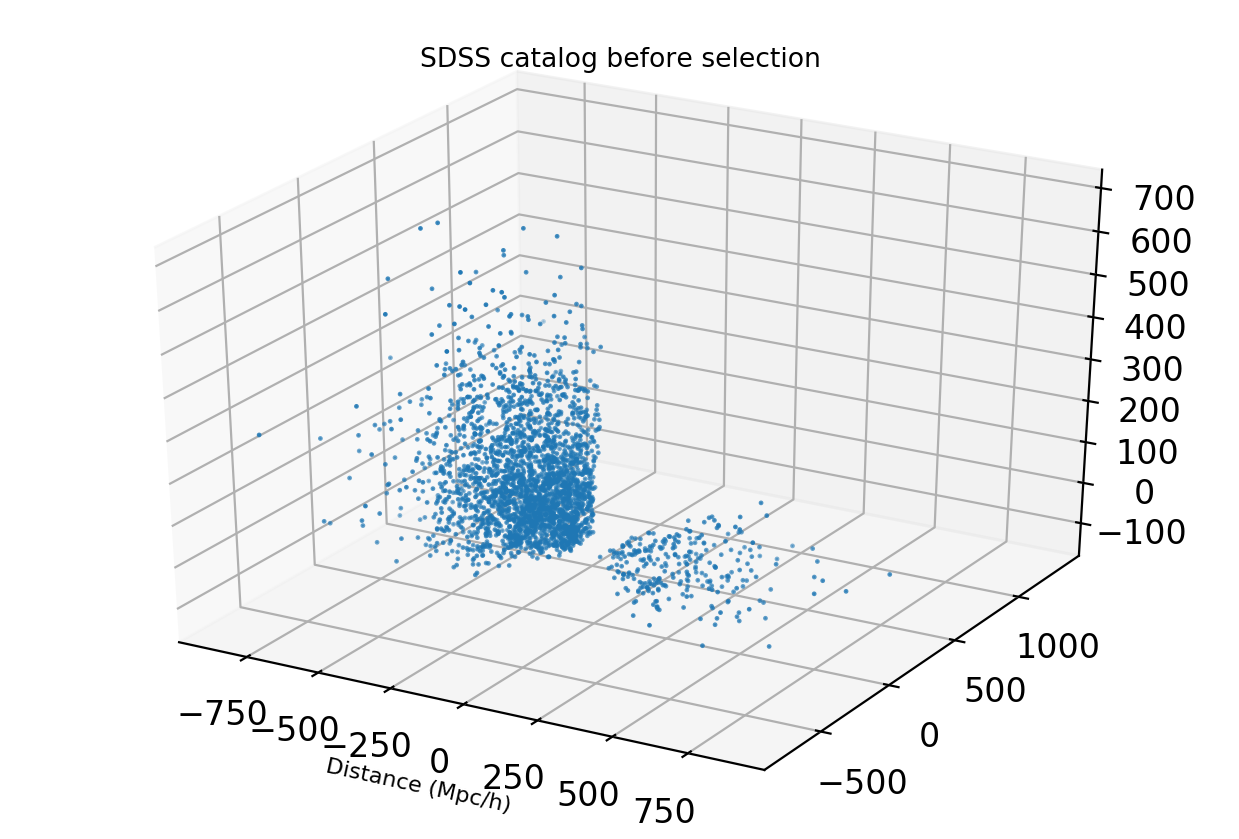

In [4]:
from astroML.datasets import fetch_sdss_specgals

# download the galaxy sample
sdss_data = fetch_sdss_specgals()
# print the names of the columns in the data
print(sdss_data.dtype.names)

# define the coordinates and redshifts of the galaxies
ra, dec, z = sdss_data['ra'], sdss_data['dec'], sdss_data['z'] 

# visualize the data in spatial coordinate 
from mpl_toolkits.mplot3d import axes3d, Axes3D 
fig = plt.figure()
ax = Axes3D(fig)
index = np.random.permutation(ra.size)[:3000]
xx, yy, zz = SkyToCar(ra[index], dec[index], z[index])
cset = ax.scatter(xx, yy, zz, s=0.5)
ax.set_xlabel('Distance (Mpc/h)',fontsize=8)

ax.clabel(cset, fontsize=9, inline=1)
plt.title('SDSS catalog before selection')
plt.show()

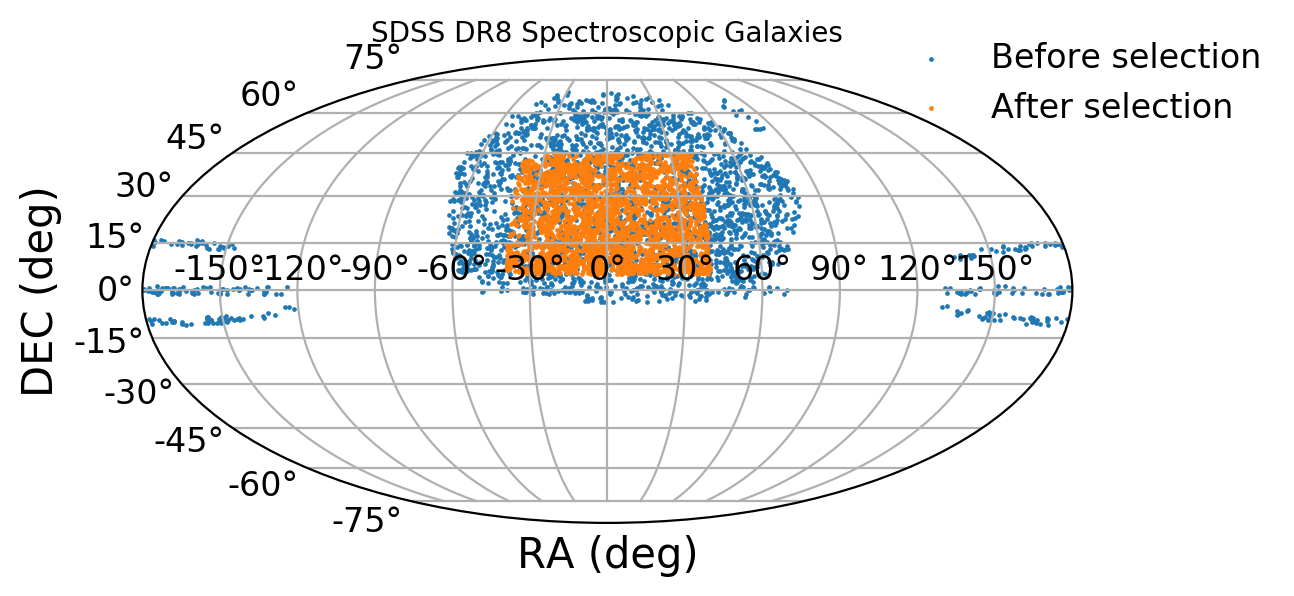

In [5]:

# data selection to have a well defined catalog
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45
dmag = sdss_data['modelMag_u'] - sdss_data['modelMag_r']
index = np.where((z>0.08)*(z<0.12)*(ra < RAmax)*(ra > RAmin)*
                 (dec <DECmax)*(dec > DECmin)*(dmag > 2.2)*
                 (sdss_data['petroMag_r']<17.7))[0]

SDSS = dict()
SDSS['ra'] = ra[index]
SDSS['dec'] = dec[index]
SDSS['z'] = z[index]

SDSS_x, SDSS_y, SDSS_z = SkyToCar(ra[index], dec[index], z[index])
SDSS['pos'] = np.array([SDSS_x,SDSS_y,SDSS_z]).T

fig = plt.figure(

)
ax = fig.add_subplot(111, projection="mollweide")

index = np.random.permutation(ra.size)[:3000]
ax.scatter((ra[index]-180)*np.pi/180, dec[index]*np.pi/180,s=0.5, label='Before selection')

index = np.random.permutation(SDSS['ra'].size)[:3000]
ax.scatter((SDSS['ra'][index]-180)*np.pi/180, SDSS['dec'][index]*np.pi/180,s=0.5, label='After selection')
ax.legend(bbox_to_anchor=(0.78, 1.1))
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
plt.title('SDSS DR8 Spectroscopic Galaxies', fontsize=10)
plt.grid(True)

Then, we read the `TNG300-3` simulation data which is a simulation with box length = $300$ Mpc/h and the label `2` after $300$ refer to the resolution, `3` is the lowest resolution (fewer particles) in `1,2,3`.
And we perform coordinate transformation and data selection.

In [6]:
basePath = '../sims.TNG/TNG300-2/output/' # data file 

# We are interested in galaxies but we know motst galaxies appear in the center of subhalo (Exception: satellite galaxies)
# so we can just read subhalo postion to be our galaxies' postion.
fields = ['SubhaloPos','SubhaloMass','SubhaloSFRinRad','SubhaloStellarPhotometrics'] 

subhalos = il.groupcat.loadSubhalos(basePath, 99, fields=fields)
TNG_pos = subhalos['SubhaloPos'] / 1000.  # cartesian coordinates in Mpc/h
mag_u, mag_r = subhalos['SubhaloStellarPhotometrics'][:,[0,5]].T # r-band and u-band magnitude

TNG_pos -= TNG_pos.mean(axis=0, keepdims=True) # shift the origin to the center

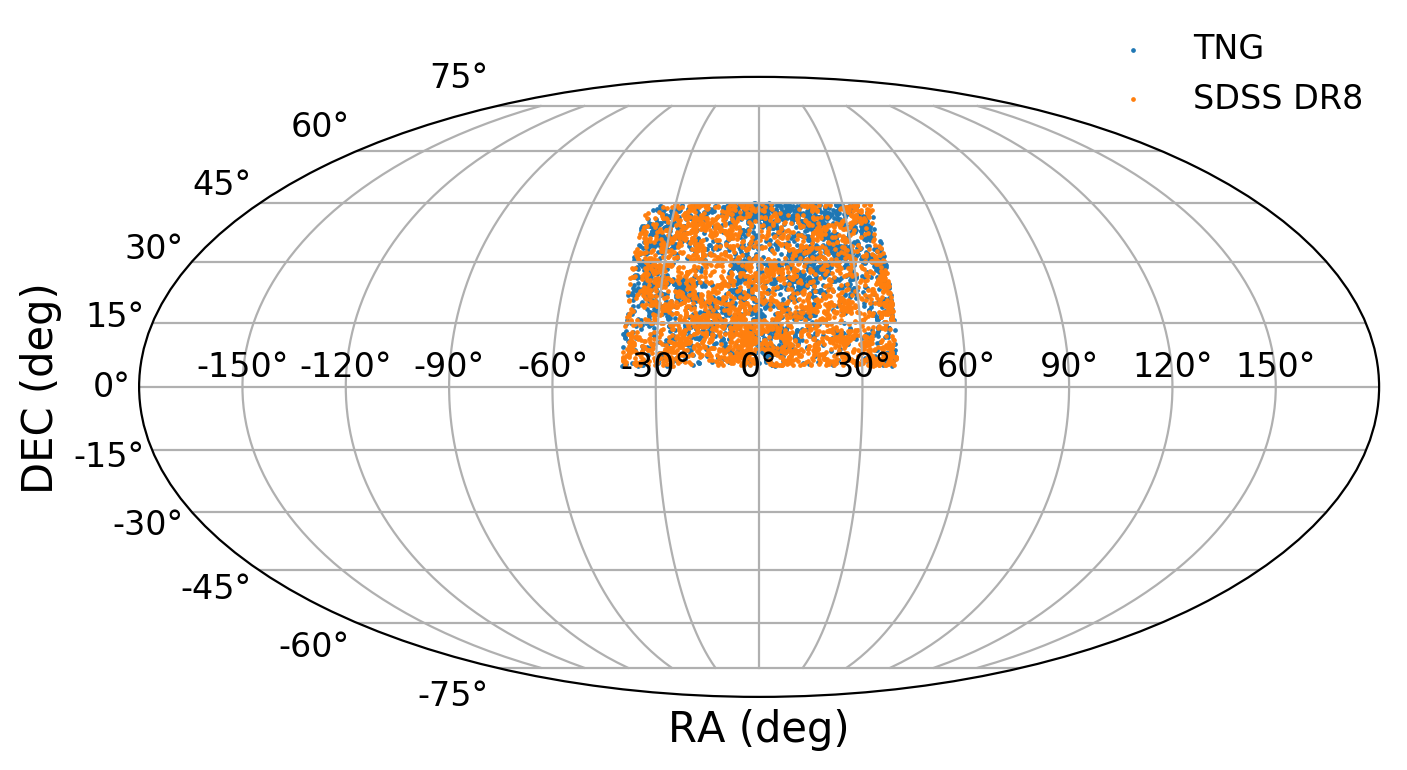

In [7]:

TNG_ra, TNG_dec, TNG_z = CarToSky(TNG_pos[:,0],TNG_pos[:,1],TNG_pos[:,2])


dmag = mag_u - mag_r
index = np.where((TNG_ra < RAmax)*(TNG_ra > RAmin)*(TNG_dec <DECmax)*(TNG_dec > DECmin)*(dmag > 1)*(mag_r<17.7))[0]

TNG = dict()
TNG['ra'] = TNG_ra[index]
TNG['dec'] = TNG_dec[index]
TNG['z'] = TNG_z[index]
TNG['pos'] = TNG_pos # [index]


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
index = np.random.permutation(TNG['ra'].size)[:3000]
ax.scatter((TNG['ra'][index]-180)*np.pi/180, TNG['dec'][index]*np.pi/180,s=0.5, label='TNG')
index = np.random.permutation(SDSS['ra'].size)[:3000]
ax.scatter((SDSS['ra'][index]-180)*np.pi/180, SDSS['dec'][index]*np.pi/180,s=0.5, label='SDSS DR8 ')
ax.legend(bbox_to_anchor=(1.02, 1.12))
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
plt.grid(True)


# Now we can compute the two point correlation function in both angular coordinate system:

In [8]:
from astroML.utils.decorators import pickle_results
from astroML.correlation import bootstrap_two_point_angular


#@pickle_results("correlation_angular.pkl")
def angular_correlation(data, bins, Nbootstraps=10, N=5000,  method='standard'):
    for d in data: N = min(N,d['ra'].size) # determine the number of galaxies being used in the analysis
    print('Evaluating two point function using',N,'galaxies')
    results = [bins]
    for d in data:
        index = np.random.permutation(d['ra'].size)[:N]
        results += bootstrap_two_point_angular(d['ra'][index], d['dec'][index],
                                               bins=bins, method=method, Nbootstraps=Nbootstraps)
    return results

data = (TNG,SDSS)

bins = 10 ** np.linspace(np.log10(1/40.), np.log10(6), 40) # define bins in log scale
(bins, TNG_corr, TNG_corr_err, TNG_bootstraps, SDSS_corr, SDSS_corr_err, SDSS_bootstraps) = angular_correlation(data, bins)


Evaluating two point function using 5000 galaxies


# Result 

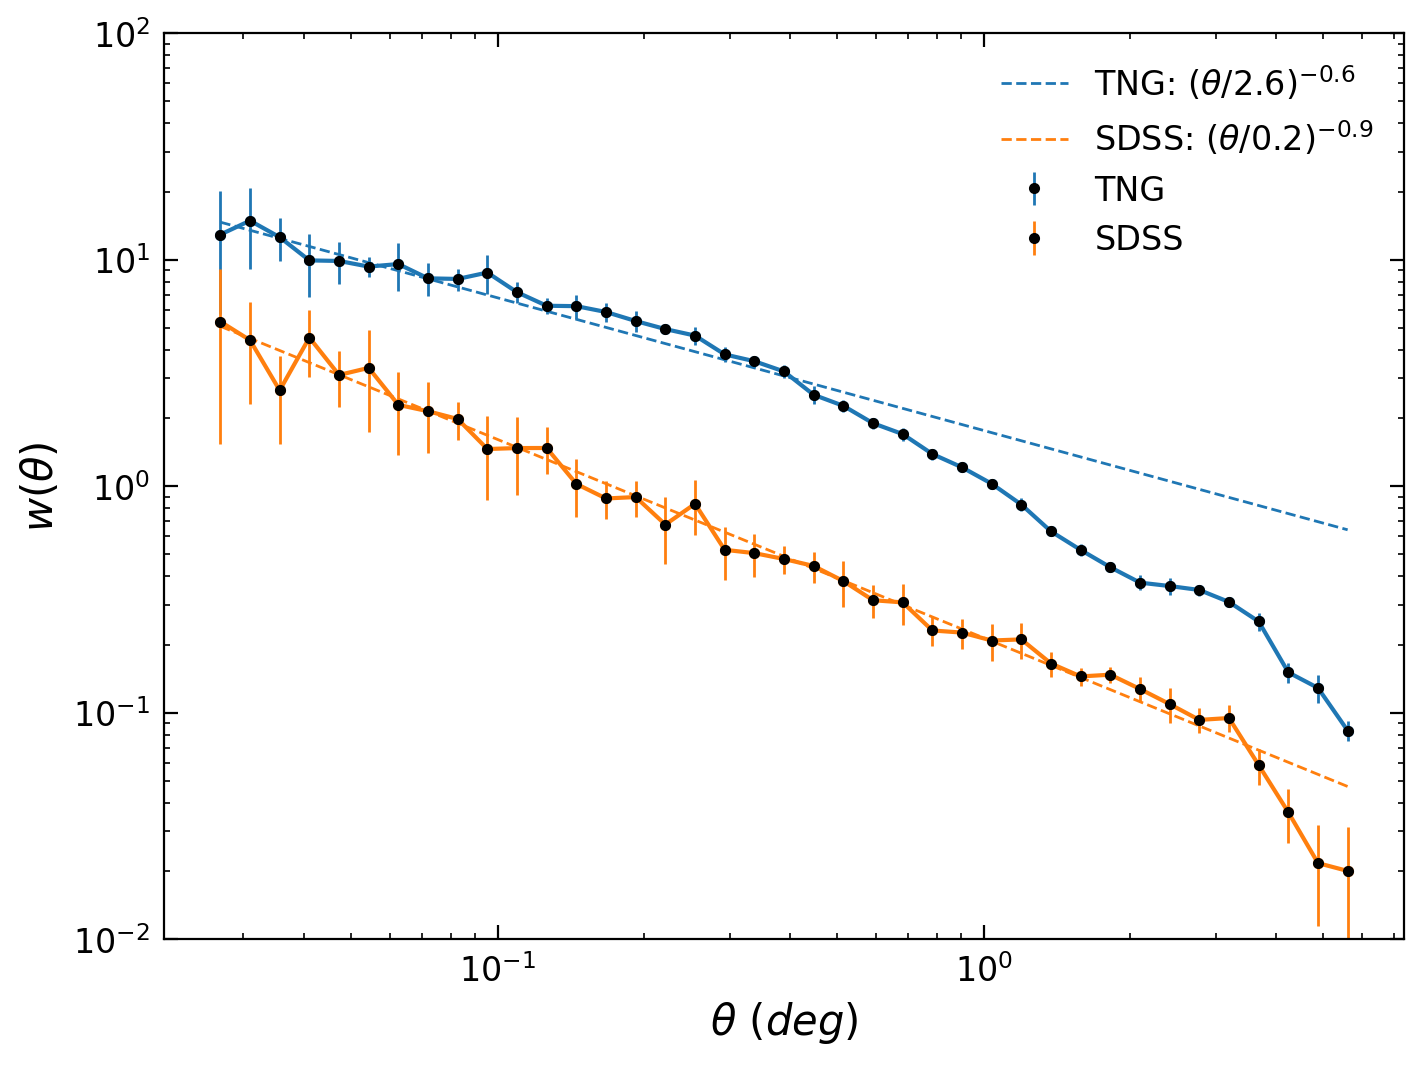

In [9]:
from scipy.optimize import curve_fit
import sys
def powerlaw(x, a, b):   
    if a <=0: return np.nan
    return (x/a)**b


theta = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(powerlaw, theta, TNG_corr, p0=[1,-1]) # fit the correlation function with power-law
popt2, pcov = curve_fit(powerlaw, theta, SDSS_corr, p0=[1,-1])


from IPython.display import display, Latex
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
corr = [TNG_corr, SDSS_corr]
corr_err = [TNG_corr_err, SDSS_corr_err]
bootstraps = [TNG_bootstraps, SDSS_bootstraps]
labels = ['TNG','SDSS']

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6),sharey=True)

for i in range(2):
    ax.errorbar(theta, corr[i], corr_err[i], fmt='.k', ecolor=colors[i], lw=1,label=labels[i])
    ax.plot(theta, corr[i], marker='.', color=colors[i])
plt.plot(theta, powerlaw(theta, *popt), color=colors[0], linewidth=1, ls='dashed', label=r'TNG:$\ (\theta / {:.1f})^{{{:.1f}}}$'.format(*popt))
plt.plot(theta, powerlaw(theta, *popt2), color=colors[1], linewidth=1, ls='dashed', label=r'SDSS:$\ (\theta / {:.1f})^{{{:.1f}}}$'.format(*popt2))
ax.set_xlabel(r'$\theta\ (deg)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-2,1e2)
ax.set_ylabel(r'$w(\theta)$')
ax.legend()
fig.savefig('./angular_300-2.pdf')
plt.show()

The blue and orange curves show the angular coorelation function for TNG data and SDSS data separately. SDSS's curve shows a weaker clustering because we use the SDSS data with redshift $0.08<z<0.12$. Higher redshift means. they move faster to escape from each other thus has weaker clustering. 

The dashed lines are the power-law fitting for both curves with 
- TNG $\sim w(\theta)= \left( \frac{\theta }{ 2.6}\right )^{-0.6}$
- SDSS $\sim w(\theta)=  \left( \frac{\theta }{ 0.2}\right )^{-0.9}$

# Now we evaluate the two point correlation function in spatial coordinate:

In [10]:
from astroML.correlation import bootstrap_two_point

#@pickle_results("correlation_spatial.pkl")
def spatial_correlation(data, bins, Nbootstraps=10, N=5000,  method='standard'):
    for d in data: 
        N = min(N,d['pos'].shape[0])
    print('Evaluating two point function using',N,'galaxies')
    results = [bins]
    for d in data:
        index = np.random.permutation(d['pos'].shape[0])[:N]
        results += bootstrap_two_point(d['pos'][index], bins=bins,
                                       method=method, Nbootstrap=Nbootstraps)
    return results

data = (TNG, SDSS)
bins = 10 ** np.linspace(np.log10(2), np.log10(30.), 40)
(bins, TNG_corr, TNG_corr_err, SDSS_corr, SDSS_corr_err) = spatial_correlation(data, bins)


Evaluating two point function using 5000 galaxies


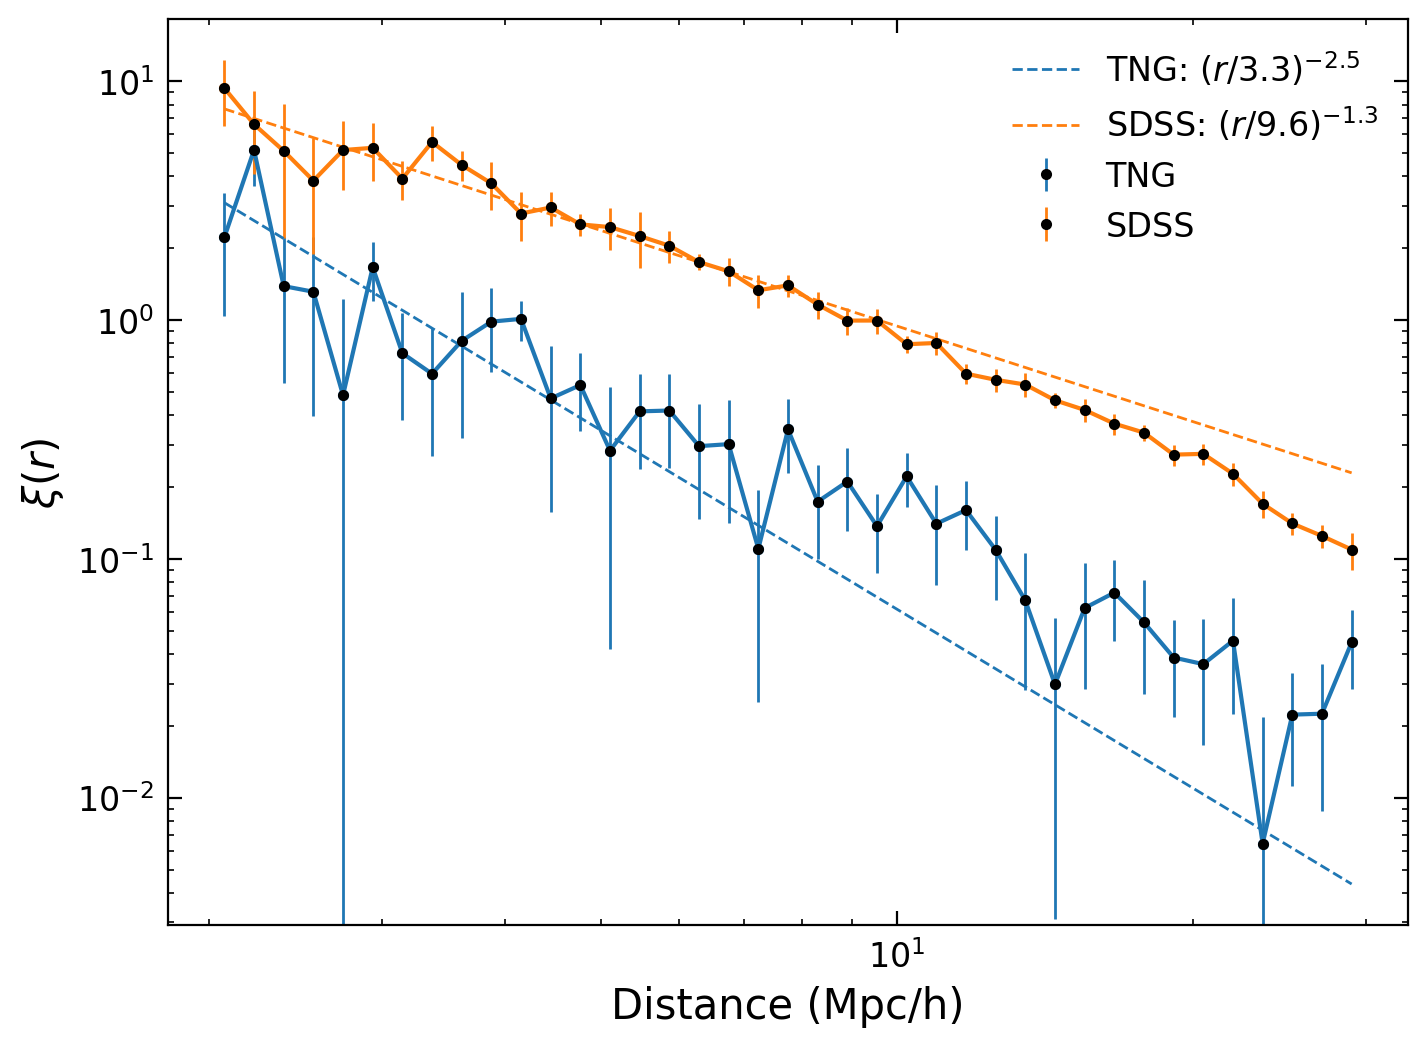

In [11]:

r = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(powerlaw, r, TNG_corr, p0=[1,-1])
popt2, pcov = curve_fit(powerlaw, r, SDSS_corr, p0=[1,-1])


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
corr = [TNG_corr, SDSS_corr]
corr_err = [TNG_corr_err, SDSS_corr_err]
bootstraps = [TNG_bootstraps, SDSS_bootstraps]
labels = ['TNG','SDSS']

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6),sharey=True)

for i in range(2):
    ax.errorbar(r, corr[i], corr_err[i], fmt='.k', ecolor=colors[i], lw=1,label=labels[i])
    ax.plot(r, corr[i], marker='.', color=colors[i])
plt.plot(r, powerlaw(r, *popt), color=colors[0], linewidth=1, ls='dashed', label=r'TNG:$\ (r / {:.1f})^{{{:.1f}}}$'.format(*popt))
plt.plot(r, powerlaw(r, *popt2), color=colors[1], linewidth=1, ls='dashed', label=r'SDSS:$\ (r / {:.1f})^{{{:.1f}}}$'.format(*popt2))

ax.set_xlabel(r'$\theta\ (deg)$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Distance (Mpc/h)')
plt.ylabel(r'$\xi (r)$')
ax.legend()
fig.savefig('./spatial_300-2.pdf')
plt.show()

The blue and orange curves show the spatial coorelation function for TNG data and SDSS data separately. SDSS's curve shows a stronger clustering. 
The dashed lines are the power-law fitting for both curves with 
- TNG $\sim \xi(r)= \left( \frac{r}{3.3}\right )^{-2.5}$
- SDSS $\sim \xi(r)=  \left( \frac{r }{ 9.6}\right )^{-1.3}$

The curve for TNG shows a relative large uncertainty, this could caused by the low resolution of the simulation. In addition, 3D correlation describe more details about the structure since we are working on 3D instead of 2D (angualr).

It's possible that SDSS has weaker clustering in angular space but stronger in spatial space. It may hints us the missing piece of radial evolution in the simulation, or the reason may be the mismatch between of redshift distribution of galaxies. 
Another reason for this coul be the survey geometry, or the selection effects from observation which can affect the clustering properties and the selection we applied when analysing the data.


# Percolation theory and clustering:

Another way to study the large-scale structure is to use percolation analysis, which is used to quantify the connectivity of the cosmic web. 
We can define galaxies to be connected to form a cluster if their separation is less than a linking length, like the diagram below.

<img src="contin_percolation.png" width="440" height="440" align="center"/>

Then, using a Friends-of-Friends (FoF) algorithm, we can estimate the fraction of largest cluster $S_0$ and second largest cluster $S_1$. 
Here, we show the result of $S_0$ vs linking length and $S_1$ vs linking length and study their characteristic.

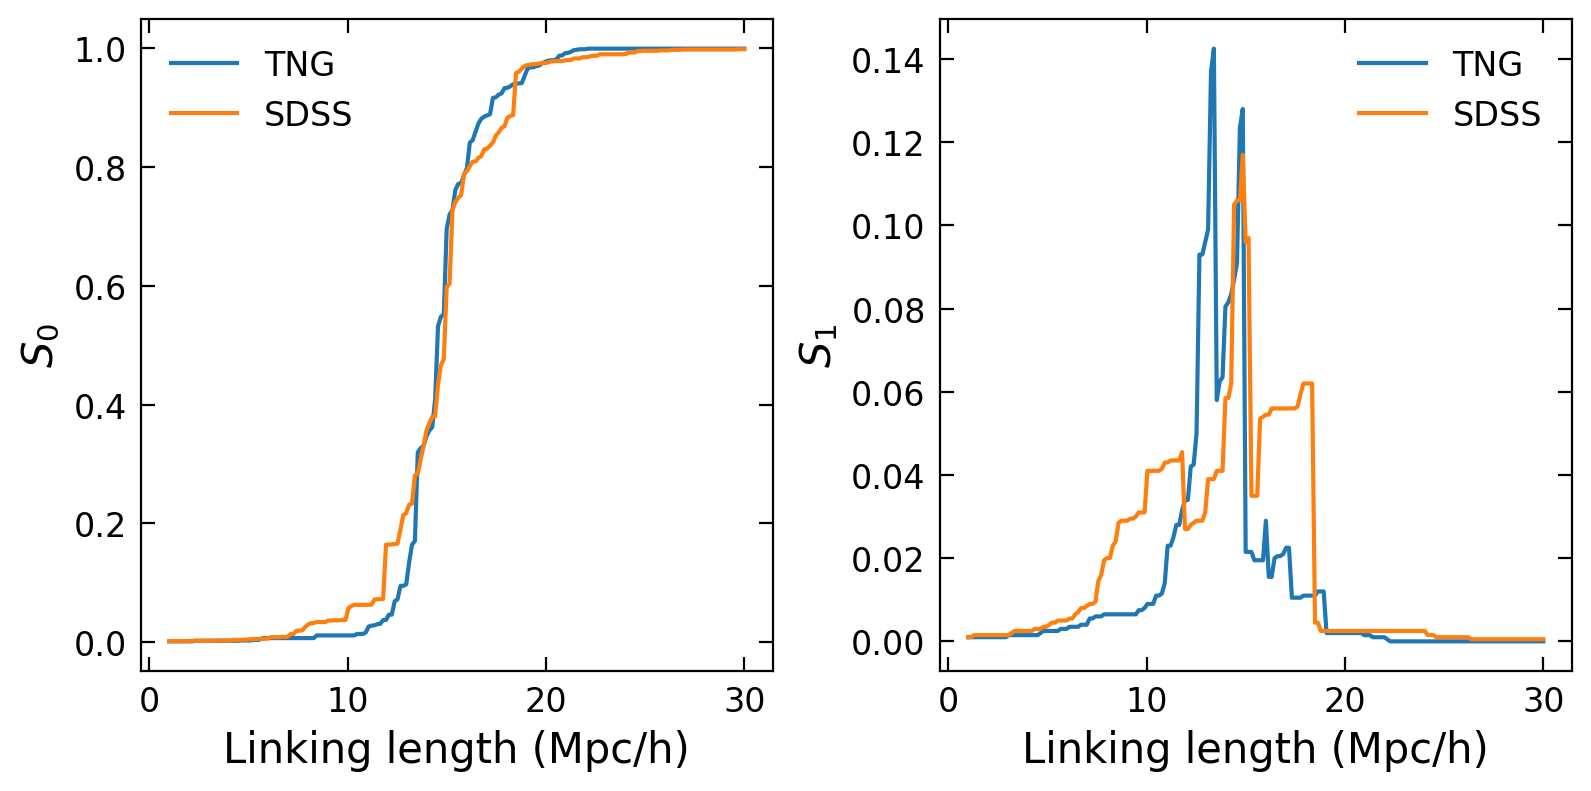

In [12]:
import pyfof    
def fof(data, bb_arr, npts=2000):
    N = data['pos'].shape[0]
    index = np.random.permutation(N)[:npts]
    data = data['pos'][index]

    Ngroup = []
    for bb in bb_arr:
        groups = pyfof.friends_of_friends(data,bb)
        try:
            Nsecond, Nlarest = np.sort(np.array([len(x) for x in groups]))[-2:]
        except:
            Nsecond, Nlargest = 0, npts
            
        Ngroup.append( [Nlarest, Nsecond])
        
    return np.array(Ngroup)

npts = 2000
bb_arr = np.linspace(1,30,200)
    
SDSSgroup = fof(SDSS, bb_arr, npts=npts)
TNGgroup = fof(TNG, bb_arr, npts=npts)


fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))

for i in range(2): 
    axes[i].plot(bb_arr, TNGgroup[:,i] / npts, label='TNG')
    axes[i].plot(bb_arr, SDSSgroup[:,i] / npts, label='SDSS')
    axes[i].set_xlabel('Linking length (Mpc/h)')
    axes[i].set_ylabel(r'$S_{}$'.format(i))
    axes[i].legend()
plt.tight_layout()


- $S_0$: Fraction of largest connected cluster
- $S_1$: Fraction of second largest connected cluster

As shown in the plot on LHS, $S_0$ has rapid increase around a certain linking length and then being saturated.

For the plot on RHS, $S_1$ reaches its maximum value around a certain linking length.

They show the phase transition characteristic. This implies the possibility that large-scale structure can be described by a simple fundamental law in terms of phase transition or symmetry breaking. 


# Conclusion:

Using two point correlation function, we can compare the large-scale structure between two huge datasets in a simple way and use it as a guidence to improve the physics in the simulation.

Using percolation analysis we found the phase transition characteristic of large-scale structure which may gives us hints on the fundamental law of physics for evolution of the Universe.